In [1]:
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from tqdm import notebook
import time
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the dataset
def load_data():
  (x_train, y_train), (_, _) = mnist.load_data()
  x_train = (x_train.astype(np.float32) - 127.5)/127.5

  # Convert shape from (60000, 28, 28) to (60000, 784)
  width = list(np.shape(x_train))[1]
  height = list(np.shape(x_train))[2]
  #channel = list(np.shape(x_train))[-1]
  x_train = x_train.reshape(60000, 784)
  return (x_train, y_train)

X_train, y_train = load_data()
print(X_train.shape, y_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 784) (60000,)


In [3]:
def build_generator():
    model = Sequential()

    model.add(Dense(units=256, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(units=512))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(units=1024))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(units=784, activation='tanh'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return model

generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               8

In [4]:
def build_discriminator():
    model = Sequential()

    model.add(Dense(units=1024 ,input_dim=784))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(units=512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(units=256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)              

In [5]:
def build_GAN(discriminator, generator):
    discriminator.trainable=False
    GAN_input = Input(shape=(100,))
    x = generator(GAN_input)
    GAN_output= discriminator(x)
    GAN = Model(inputs=GAN_input, outputs=GAN_output)
    GAN.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return GAN

GAN = build_GAN(discriminator, generator)
GAN.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 784)               1486352   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [6]:
def draw_images(generator, epoch, examples=25, dim=(5,5), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(25,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='Greys')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('Generated_images %d.png' %epoch)
    

Epoch 1



Epoch 2



Epoch 3



Epoch 4



Epoch 5



Epoch 6



Epoch 7



Epoch 8



Epoch 9



Epoch 10



Epoch 11



Epoch 12



Epoch 13



Epoch 14



Epoch 15



Epoch 16



Epoch 17



Epoch 18


KeyboardInterrupt: ignored

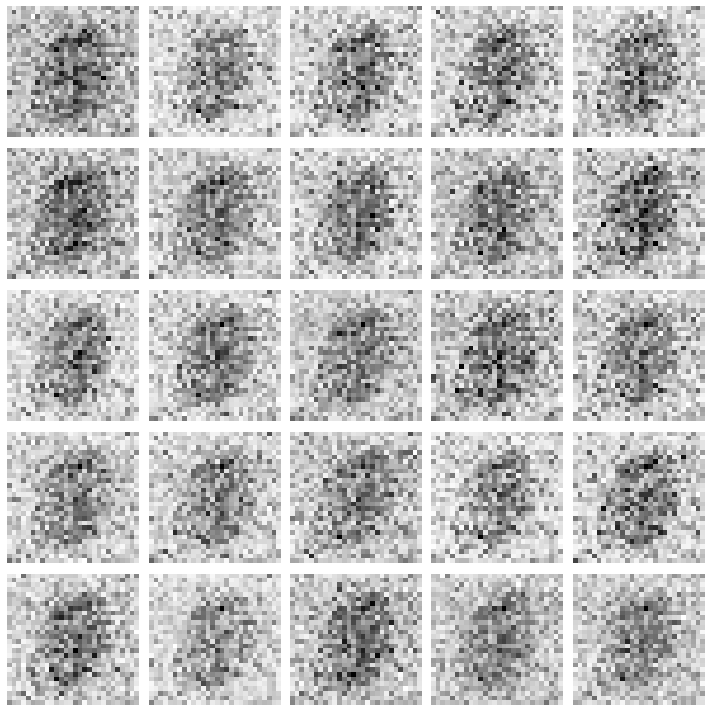

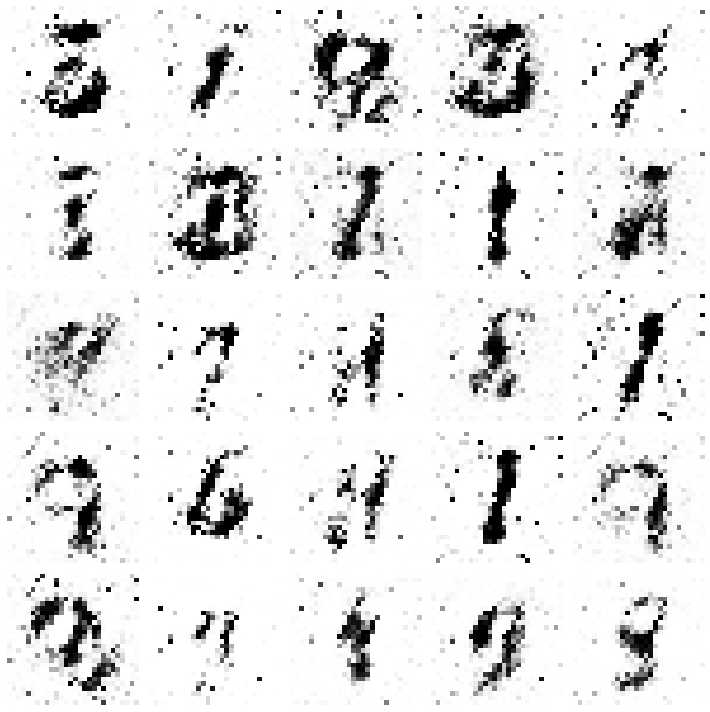

In [11]:
def train_GAN(epochs=1, batch_size=128):

  #Loading the data
  X_train, y_train = load_data()

  # Creating GAN
  generator= build_generator()
  discriminator= build_discriminator()
  GAN = build_GAN(discriminator, generator)

  for i in range(1, epochs+1):
    print("Epoch %d" %i)
    time.sleep(0.5)
    
    for _ in notebook.tqdm(range(batch_size)):
      # Generate fake images from random noiset
      noise= np.random.normal(0,1, (batch_size, 100))
      fake_images = generator.predict(noise)

      # Select a random batch of real images from MNIST
      real_images = X_train[np.random.randint(0, X_train.shape[0], batch_size)]

      # Labels for fake and real images           
      label_fake = np.zeros(batch_size)
      label_real = np.ones(batch_size) 

      # Concatenate fake and real images 
      X = np.concatenate([fake_images, real_images])
      y = np.concatenate([label_fake, label_real])

      # Train the discriminator
      discriminator.trainable=True
      discriminator.train_on_batch(X, y)

      # Train the generator/chained GAN model (with frozen weights in discriminator) 
      discriminator.trainable=False
      GAN.train_on_batch(noise, label_real)

    # Draw generated images every 15 epoches     
    if i == 1 or i % 10 == 0:
      draw_images(generator, i)
train_GAN(epochs=400, batch_size=128) #(main)

In [8]:
import os